In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
N=50
q=0.05
G=nx.erdos_renyi_graph(N,q)

In [5]:
# directed graph with weighted edges (https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.add_weighted_edges_from.html)

G = nx.DiGraph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from([(0, 1, 3.0), (1, 2, 7.5)])

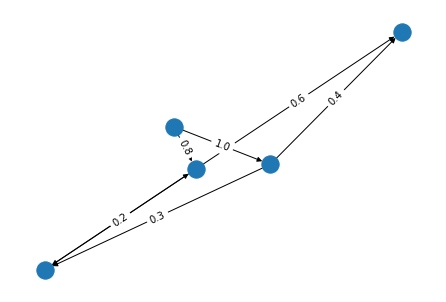

In [6]:
# https://stackoverflow.com/questions/56597840/drawing-weighted-graph-from-adjacency-matrix-with-edge-labels
# Directed weighted graph from weighted Adjacency Matric (matrix C in J. Lizier paper)

A = [
    [0, 1,  0,  .8, 0],
    [0, 0,  .4, 0,  .3],
    [0, 0,  0,  0,  0],
    [0, 0,  .6, 0,  .7],
    [0, 0,  0,  .2, 0]]

G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
layout = nx.spring_layout(G)
nx.draw(G, layout)
#nx.draw_networkx_edge_labels(G, pos=layout)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)
plt.show()

In [28]:
edges_attributes_dict_keys = next(iter(G.edges(data=True)))[2].keys()
edges_attributes_dict_keys

if (not 'weight' in edges_attributes_dict_keys):
    print('bla no weights')

bla no weights


In [26]:
nodes_attributes_dict = next(iter(G.nodes(data=True)))[1]
nodes_attributes_dict

if ('weight' in 

{}

In [8]:
# Visualize weighted graph (https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html)

def plotWeightedGraph(G: nx.DiGraph, weight_attribute='weight'):
    ''' Plot weighted graph'''

    
    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d[weight_attribute] > 5]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d[weight_attribute] <= 5]

    pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, weight_attribute)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

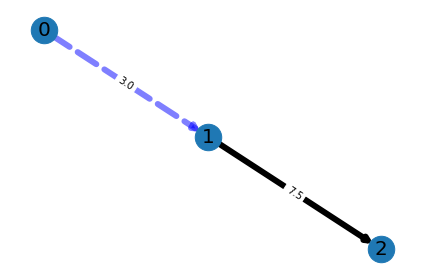

In [9]:
plotWeightedGraph(G)

In [11]:

import copy

def initialize_nodes_values(g):
    ''' setup initial x values on graph g'''
    for node in g.nodes():
        g.nodes[node]['x']=0.1

def initialize_edges_weights(g):
    for edge in g.edges():
        g.edges[edge]['weight']=0.1


class ProcessOnNetwork(): 
    def __init__(self, G):
        super().__init__()

        # Processing parameters

        # allowed_kwargs = {'initializer'}
        # for kwarg in kwargs.keys():
        #     assert kwarg in allowed_kwargs, 'Invalid keyword argument: ' + kwarg
        # initi = kwargs.get('blob')

        # properties

        self.g = copy.deepcopy(G)
        self.C = nx.to_numpy_array(G)
        self.node_initializer = initialize_nodes_values
        self.edge_weight_initializer = initialize_edges_weights
        self.N = G.number_of_nodes

        # check graph has weights on its edges

        edges_attributes_dict_keys = next(iter(self.g.edges(data=True)))[2].keys()

        if (not 'weight' in edges_attributes_dict_keys):
            print('This network has no weights on its edges, initializing with random values')
            self.edge_weight_initializer(self.g)

        # initialize node values
        self.node_initializer()
            
    def initialize(self):
        self.node_initializer()


    def update(self, dt=0.001):
        # 
        N = self.N

        # take X the value of the dynamical process on each node as a row vector
        X = np.array(nx.get_node_attributes(self.g, 'x')).reshape(1, N)

        # Weighted adjacency matrix
        C = self.C

        # I - C
        I = np.identity(N)
        I_C = I - C

        # dw Wiener process

        dW= np.sqrt(dt)*np.random.standard_normal(X.shape)

        dX = -X * I_C * dt + dW

        Xnew = X + dX

        nx.set_node_attributes(self.g, values=Xnew, name='x')


In [15]:
G.nodes(data=True)
for node in G.nodes():
    G.nodes[node]['x']=0.1

In [16]:
for edge in G.edges():
    G.edges[edge]['weight']=0.1

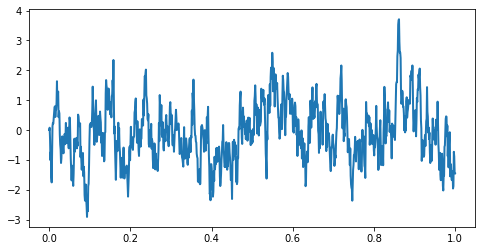

In [22]:
# https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/

dt = .001  # Time step.
T = 1.  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.

sigma = 1.  # Standard deviation.
mu = 0.  # Mean.
tau = 0.01 #.05  # Time constant.

sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

x = np.zeros(n)

for i in range(n - 1):
    x[i + 1] = x[i] + dt * (-(x[i] - mu) / tau) + \
        sigma_bis * sqrtdt * np.random.randn()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(t, x, lw=2)

In [25]:
# Wiener DW using Euler-Maruyama (https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/)

# 
'''

dx = a(t,x)dt + b(t,x)dw

--> discretise time 

t = n * dt

xn+1 = xn + dx = xn + a(t,xn)dt + b(t,xn) * sqrt(dt) * N(0,1)
'''

X = np.random.standard_normal((1,10))
dt=0.001
dW= np.sqrt(dt)*np.random.standard_normal(X.shape)
dW

array([[ 0.01685208,  0.0181457 , -0.01906413,  0.01151455,  0.01182954,
         0.00681198,  0.03647638, -0.00827636, -0.03311247, -0.05571611]])

In [50]:
# TEST How to stack the x(t) matrices for each nodes of the network at each time step

import numpy as np

array = np.array([[1,2,3],[4,5,6],[7,8,9]]).reshape(1,3,3)
print(array.shape)

# array = np.expand_dims(array, axis = 2)
# print(array.shape)

X = np.random.standard_normal((3,3)).reshape(1,3,3)
X2 = np.random.standard_normal((3,3)).reshape(1,3,3)

#array = np.stack([array,X], axis=0)
array = np.vstack((array,X))
print(array)

print(array[0])

print(array[1])
print(X2)

print("vstack -------------------------")

array = np.vstack((array,X2))

print(array[2])


(1, 3, 3)
[[[ 1.          2.          3.        ]
  [ 4.          5.          6.        ]
  [ 7.          8.          9.        ]]

 [[ 0.24502677  1.06231214 -0.50876436]
  [ 1.59247385 -1.63678404  1.00452018]
  [-0.08087132 -1.83989337  0.8403857 ]]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[ 0.24502677  1.06231214 -0.50876436]
 [ 1.59247385 -1.63678404  1.00452018]
 [-0.08087132 -1.83989337  0.8403857 ]]
[[[ 2.17326051 -0.56735649  0.62690253]
  [-1.30649626  1.05531738 -0.7560109 ]
  [-0.03307711 -0.92075987 -1.53562049]]]
vstack -------------------------
[[ 2.17326051 -0.56735649  0.62690253]
 [-1.30649626  1.05531738 -0.7560109 ]
 [-0.03307711 -0.92075987 -1.53562049]]
